# Age Detection of Indian Actors

This problem is taken from below link:

https://datahack.analyticsvidhya.com/contest/practice-problem-age-detection/

Facial feature analysis has always been a topic of interest mainly due to its applicability. Deep Learning techniques are now making it possible for face analysis to be not just a dream but a reality. This practice problem is get you more acquainted with deep learning.

## Problem Statement:

Indian Movie Face DataBase(IMFDB) is a large unconstrained face database consisting of 34512 images of 100 Indian actors collected from more than 100 videos. All the images are manually selected and cropped from the video frames resulting in a high degree of variability interms of scale, pose, expression, illumination, age, resolution, occlusion and makeup. IMFDB is the first face database that provides a detailed annotation of every image in terms of age, pose, gender, expression and type of occlusion that may help other face related applications.

### Data

The dataset is cleaned and formatted to give you a total of 26742 images with 19906 images in train and 6636 images in test.

The attributes of data are as follows:

ID-Unique ID of image

Class-Age bin of person in image

### Objective:
The task is to predict the age of a person from his or her facial attributes. For simplicity, the problem has been converted to a multiclass problem with classes as Young, Middle and Old.

## Loding Images

In [1]:
#Importing
%pylab inline
import os
import random
import cv2
import pandas as pd
import numpy as np
import scipy
import sklearn

Populating the interactive namespace from numpy and matplotlib


In [22]:
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import PIL
import pandas as pd
from PIL import Image

#from keras.preprocessing import image
#from keras.preprocessing import load_img,img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD,Adam,Adamax
from keras.layers import Input
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Model,load_model
from keras.layers import Dense,Dropout,Flatten, Conv2D,MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

In [2]:
train = pd.read_csv('train.csv')

In [3]:
test = pd.read_csv('test.csv')

In [4]:
train.shape

(19906, 2)

In [5]:
test.shape

(6636, 1)

In [6]:
train.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [7]:
test.head()

,ID
0,25321.jpg
1,989.jpg
2,19277.jpg
3,13093.jpg
4,5367.jpg


In [8]:
train.groupby(by = "Class").count()

,ID
Class,
MIDDLE,10804
OLD,2396
YOUNG,6706


Age: YOUNG


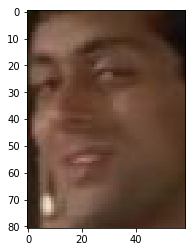

In [10]:
#Random image and its lable from train data set
import os
import random
import cv2
import pandas as pd
import numpy as np
import scipy
import sklearn
i = random.choice(train.index)
img_name = train.ID[i]
img = imread(os.path.join('Train', img_name))
print("Age:" , train.Class[i])
imshow(img)

### Preprocessing images data

#### Resizing images of train and test data

In [9]:
#reference:https://www.analyticsvidhya.com/blog/2017/06/architecture-of-convolutional-neural-networks-simplified-demystified/

In [11]:
#Loading the Images
from scipy.misc import imresize
train_images=[]
for img_name in train.ID:
    trainpath = os.path.join('Train',img_name)
    image = imread(trainpath)
    image = imresize(image, (64,64))
    image = image.astype('float32')
    train_images.append(image)
    
train_x = np.stack(train_images)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


In [12]:
test_images=[]
for img_name in test.ID:
    testpath = os.path.join('Test',img_name)
    image = imread(testpath)
    image = imresize(image, (64,64))
    image = image.astype('float32')
    test_images.append(image)
    
test_x = np.stack(test_images)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


In [13]:
len(train_x)

19906

In [14]:
len(test_x)

6636

In [15]:
#Normalizing pixels
train_x = train_x/255
test_x = test_x/255

In [16]:
#Label encoder
import keras
from sklearn.preprocessing import LabelEncoder
#Converting target variable to categorical variable
label = LabelEncoder()
train_y = label.fit_transform(train.Class)
train_y = keras.utils.np_utils.to_categorical(train_y)

Using TensorFlow backend.


In [17]:
train_y

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [18]:
train_x.shape,test_x.shape,train_y.shape,

((19906, 64, 64, 3), (6636, 64, 64, 3), (19906, 3))

In [19]:
#Splitting train data into Train and Test

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15924, 64, 64, 3), (3982, 64, 64, 3), (15924, 3), (3982, 3))

In [23]:
#initialize the training data augmentation object
trainAug = ImageDataGenerator(
            featurewise_center=True,
            featurewise_std_normalization=True,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True)

In [24]:
trainAug.fit(X_train)

In [25]:
testAug = ImageDataGenerator(
            featurewise_center=True,
            featurewise_std_normalization=True,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True)

In [26]:
testAug.fit(X_test)

In [27]:
X_train.shape

(15924, 64, 64, 3)

In [28]:
X_test.shape

(3982, 64, 64, 3)

In [29]:
testAug.fit(test_x)

In [30]:
test_x.shape

(6636, 64, 64, 3)

In [31]:
y_test.shape

(3982, 3)

### Building Models using convolution neural network

#### Defining the Architecture of Convolution2D

In [62]:
#Initializing the sequential model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [63]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
activation_111 (Activation)  (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
activation_112 (Activation)  (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 64)        18496     
__________

In [64]:
model.fit(train_x, train_y, batch_size=32, epochs=40,verbose=1)
model.save_weights('weights.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/40
19906/19906 [==============================] - 488s 25ms/step - loss: 0.5158 - acc: 0.7467
Epoch 2/40
19906/19906 [==============================] - 500s 25ms/step - loss: 0.4629 - acc: 0.7854
Epoch 3/40
19906/19906 [==============================] - 577s 29ms/step - loss: 0.4334 - acc: 0.8017
Epoch 4/40
19906/19906 [==============================] - 472s 24ms/step - loss: 0.4156 - acc: 0.8135
Epoch 5/40
19906/19906 [==============================] - 495s 25ms/step - loss: 0.4013 - acc: 0.8204
Epoch 6/40
19906/19906 [==============================] - 496s 25ms/step - loss: 0.3876 - acc: 0.8282
Epoch 7/40
19906/19906 [==============================] - 459s 23ms/step - loss: 0.3802 - acc: 0.8342
Epoch 8/40
19906/19906 [==============================] - 481s 24ms/step - loss: 0.3717 - acc: 0.8383
Epoch 9/40
19906/19906 [==============================] - 455s 23ms/step - loss: 0.3659 - acc: 0.8413
Epoch 10/40
19906/19906 [=========

#### Predicting on Test data

In [65]:
pred = model.predict_classes(test_x)
pred = label.inverse_transform(pred)

test['Class'] = pred
test.to_csv('submission_age.csv', index=False)

In [ ]:
preds = model_vgg16.evaluate(X_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

### Pretrained Models

In [34]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

img_height,img_width = 64,64
num_classes = 3
#If imagenet weights are being loaded,input must have a static square shape
base_model = ResNet50(weights=None, include_top=False, input_shape=(img_height,img_width,3))

In [35]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model_resnet = Model(inputs=base_model.input, outputs=predictions)

W0926 12:43:37.903225 140149613623040 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [36]:
model_resnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [37]:
from keras.optimizers import SGD, Adam
adam = Adam(lr=0.0001)
model_resnet.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [38]:
checkpoint = ModelCheckpoint("model_resnet.h5",monitor="val_loss",mode="min",save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor="val_loss",mode="min",min_delta=0,patience=10,verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=1,verbose=1,min_delta=0.0001)
#tensorboard = TensorBoard(log_dir="graph_1",histogram_freq=0,batch_size=128,write_graph=True,write_grads=False,
#                            write_images=False,embeddings_freq=0,embeddings_layer_names=None,embeddings_metadata=None,
#                            embeddings_data=None,update_freq='epoch')
callbacks = [checkpoint,earlystop,reduce_lr]

In [39]:
model_resnet.fit(X_train,y_train,epochs=30,batch_size=512,validation_data=(X_test,y_test),callbacks=callbacks)
#model_resnet.save_weights('model_resnet.h5')

W0926 12:43:45.719814 140149613623040 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 15924 samples, validate on 3982 samples
Epoch 1/30
15924/15924 [==============================] - 725s 46ms/step - loss: 1.8656 - acc: 0.4371 - val_loss: 1.5856 - val_acc: 0.5515

Epoch 00001: val_loss improved from inf to 1.58556, saving model to model_resnet.h5
Epoch 2/30
15924/15924 [==============================] - 698s 44ms/step - loss: 1.4423 - acc: 0.4793 - val_loss: 1.4336 - val_acc: 0.5520

Epoch 00002: val_loss improved from 1.58556 to 1.43361, saving model to model_resnet.h5
Epoch 3/30
15924/15924 [==============================] - 698s 44ms/step - loss: 1.2791 - acc: 0.5008 - val_loss: 1.1826 - val_acc: 0.5472

Epoch 00003: val_loss improved from 1.43361 to 1.18256, saving model to model_resnet.h5
Epoch 4/30
15924/15924 [==============================] - 697s 44ms/step - loss: 1.1788 - acc: 0.5369 - val_loss: 1.2901 - val_acc: 0.5779

Epoch 00004: val_loss did not improve from 1.18256

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05

In [40]:
preds = model_resnet.evaluate(X_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

3982/3982 [==============================] - 26s 7ms/step
Loss = 0.9465157491726112
Test Accuracy = 0.5909090909240594


In [41]:
model_resnet.load_weights(os.path.join("model_resnet.h5"))
pred = model_resnet.predict(test_x)

In [42]:
pred.shape

(6636, 3)

In [44]:
#pred = model.predict_classes(test_x)
pred= np.argmax(pred,axis=1)

In [45]:
test['Class'] = pred
test.to_csv('submission_age_resnet.csv', index=False)

In [32]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

img_height,img_width = 64,64
num_classes = 3
#If imagenet weights are being loaded,input must have a static square shape
base_model = VGG16(weights=None, include_top=False, input_shape=(img_height,img_width,3))

W0927 08:51:32.478157 140247048369920 deprecation_wrapper.py:119] From /home/jupyter/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0927 08:51:32.779580 140247048369920 deprecation_wrapper.py:119] From /home/jupyter/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0927 08:51:32.913552 140247048369920 deprecation_wrapper.py:119] From /home/jupyter/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0927 08:51:33.113555 140247048369920 deprecation_wrapper.py:119] From /home/jupyter/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [33]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model_vgg16 = Model(inputs=base_model.input, outputs=predictions)

W0927 08:51:44.187951 140247048369920 deprecation_wrapper.py:119] From /home/jupyter/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0927 08:51:44.196738 140247048369920 deprecation.py:506] From /home/jupyter/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0927 08:51:44.197654 140247048369920 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [34]:
model_vgg16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

In [35]:
from keras.optimizers import SGD, Adam
adam = Adam(lr=0.0001)
model_vgg16.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

W0927 08:52:41.866947 140247048369920 deprecation_wrapper.py:119] From /home/jupyter/.local/lib/python3.5/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0927 08:52:41.874631 140247048369920 deprecation_wrapper.py:119] From /home/jupyter/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:3576: The name tf.log is deprecated. Please use tf.math.log instead.



In [36]:
checkpoint = ModelCheckpoint("model_vgg16.h5",monitor="val_loss",mode="min",save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor="val_loss",mode="min",min_delta=0,patience=5,verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=1,verbose=1,min_delta=0.0001)
callbacks = [checkpoint,earlystop,reduce_lr]

In [37]:
model_vgg16.fit(X_train,y_train,epochs=20,batch_size=512,validation_data=(X_test,y_test),callbacks=callbacks)
#model.save_weights('model_vgg16.h5')

W0927 08:52:58.929013 140247048369920 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 15924 samples, validate on 3982 samples
Epoch 1/20
15924/15924 [==============================] - 771s 48ms/step - loss: 0.9835 - acc: 0.5261 - val_loss: 0.9499 - val_acc: 0.5477

Epoch 00001: val_loss improved from inf to 0.94994, saving model to model_vgg16.h5
Epoch 2/20
15924/15924 [==============================] - 773s 49ms/step - loss: 0.9547 - acc: 0.5409 - val_loss: 0.9407 - val_acc: 0.5477

Epoch 00002: val_loss improved from 0.94994 to 0.94066, saving model to model_vgg16.h5
Epoch 3/20
15924/15924 [==============================] - 759s 48ms/step - loss: 0.9464 - acc: 0.5402 - val_loss: 0.9524 - val_acc: 0.5477

Epoch 00003: val_loss did not improve from 0.94066

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 4/20
15924/15924 [==============================] - 760s 48ms/step - loss: 0.9332 - acc: 0.5410 - val_loss: 0.9152 - val_acc: 0.5477

Epoch 00004: val_loss improved from 0.94066 to 0.91520, saving model to model_vgg16.h5
E

In [38]:
preds = model_vgg16.evaluate(X_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

3982/3982 [==============================] - 41s 10ms/step
Loss = 0.7481389540873958
Test Accuracy = 0.6662481165842337


In [39]:
model_vgg16.load_weights(os.path.join("model_vgg16.h5"))
pred = model_vgg16.predict(test_x)

In [41]:
#pred = model.predict_classes(test_x)
#pred = label.inverse_transform(pred)
pred= np.argmax(pred,axis=1)
test['Class'] = pred
test.to_csv('submission_age_vgg16.csv', index=False)

In [1]:
from prettytable import PrettyTable
pretty_table = PrettyTable()
pretty_table.field_names = ["Model", "Accuracy", "Train loss"]
pretty_table.add_row(["CNN","0.85","0.35"])
pretty_table.add_row(["Pre-trained ResNet50","0.61","0.94"])
pretty_table.add_row(["Pre-trained VGG16","0.65","0.75"])

print(pretty_table)

+----------------------+----------+------------+
|        Model         | Accuracy | Train loss |
+----------------------+----------+------------+
|         CNN          |   0.85   |    0.35    |
| Pre-trained ResNet50 |   0.61   |    0.94    |
|  Pre-trained VGG16   |   0.65   |    0.75    |
+----------------------+----------+------------+


Conclusion:
    As performance was not improved for all the models as it is shown for simple CNN model train accuracy and loss is 
    better so predicted class labels on test data,stored in csv file for submitting it into competition.